## Lesson 21 - Google Play BERT Sentiment Classifier




### Table of Contents
* [Import and download package](#import)
* [Load Dataset](#load)
* [Prepare training , validation  data](#training_data)
* [Decide max_len](#max_len)
* [Dataset and Dataloader](#dataset)
* [Model Selection](#model_selection)
* [Load our own bert model](#load_own_bert)
* [Testing model performance on unseen data](#testing)


<a id="import"></a>
## Import and download package

In [1]:
import torch
import json
import pickle
import pandas as pd
import numpy as np
# import swifter
import torch.nn as nn

from tqdm import tqdm
from transformers import BertModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
!pip install -U sentence-transformers

  Using cached sentence_transformers-2.2.2-py3-none-any.whl
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached sentencepiece-0.1.99-cp37-cp37m-win_amd64.whl (977 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)


In [3]:
from sentence_transformers import SentenceTransformer, util

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
from matplotlib.font_manager import FontProperties

# Windows
myfont = FontProperties(fname=r'C:\Windows\Fonts\kaiu.ttf',size=14)

# Mac OS
# myfont = FontProperties(fname="/Users/mac/Library/Fonts/NotoSansHant-Medium.otf", size=14)
sns.set(font=myfont.get_name())

In [5]:
## Setting up some global variable

COLORS = ['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
from torch.utils import data
sns.set_palette(sns.color_palette(COLORS))
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
fig_size = (10,7)

<a id="load"></a>
## Load data

In [6]:
df_all =  pd.read_csv('data/sentimental/googleplay/google_play_big.csv', sep=',' , encoding='utf-8', engine='python')
df_all = df_all.replace(np.nan, '', regex=True)
df_all = df_all[(df_all.ratings ==1.0) | (df_all.ratings == 2.0) | (df_all.ratings == 3.0) | (df_all.ratings == 4.0) | (df_all.ratings == 5.0)]

if 'Unnamed: 0' in df_all.columns:
    df_all = df_all.drop(['Unnamed: 0'], axis=1)
if '_id' in df_all.columns:
    df_all = df_all.drop(['_id'], axis=1)

df_all["wordcount"] = df_all["comments"].apply(lambda x: len(str(x)))
print(df_all.shape)
df_all.head()

(349441, 3)


,comments,ratings,wordcount
0,6/27好不容易等到更新了，結果左下個人資料點了會斷線重連的bug竟然還是沒修好，雖然硬要...,1.0,114
1,好玩 可是我手機名明明放在桌上 人物卻會一直亂跑 系統都判定我在開車...,5.0,38
2,花了錢買道具吸引怪，卻沒有吸引多少怪可以打，走好幾公里的路也沒打到幾隻怪，再這麽少怪，玩家...,1.0,74
3,等到更新後，仍然卡在「請眼觀四面耳聽八方」，無法進入遊戲。 手機是Sony XZ2. 真的...,1.0,65
4,我今天剛下載了這款遊戲，玩了一陣子後，我有點擊左下角的一個人物頭像，但是它顯示了無線網路發...,3.0,153


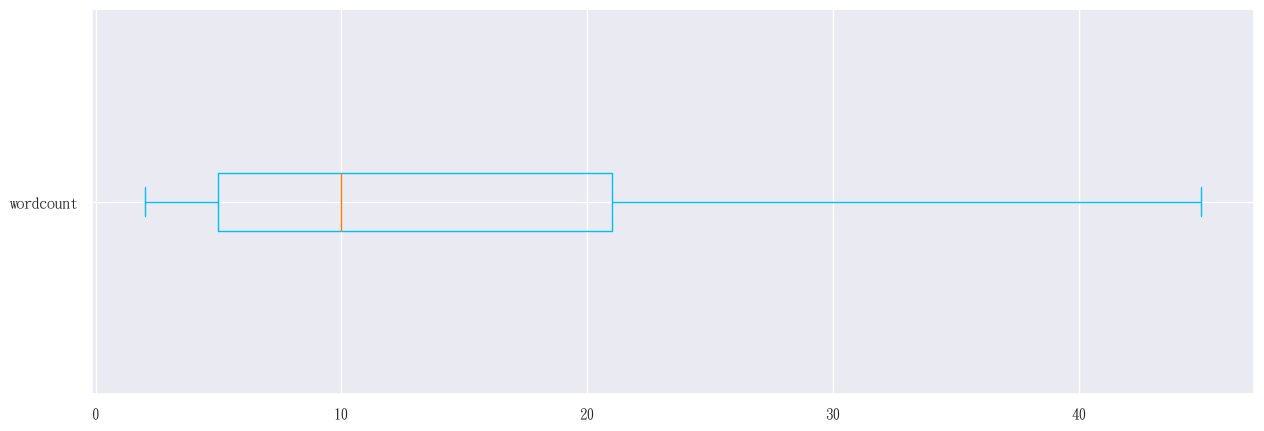

In [7]:
plot = df_all[['wordcount']].plot.box(figsize=(15,5), vert=False, showfliers=False)

In [8]:
d_1 = df_all[(df_all.ratings==1.0) & (df_all.wordcount>10) & (df_all.wordcount<25)]
d_2 = df_all[(df_all.ratings==2.0) & (df_all.wordcount>10) & (df_all.wordcount<25)]
d_3 = df_all[(df_all.ratings==3.0) & (df_all.wordcount>10) & (df_all.wordcount<25)]
d_4 = df_all[(df_all.ratings==4.0) & (df_all.wordcount>10) & (df_all.wordcount<25)]
d_5 = df_all[(df_all.ratings==5.0) & (df_all.wordcount>10) & (df_all.wordcount<25)]
d_2.shape[0]

4502

In [9]:
num_to_pick = 45000
num_to_pick = 1250
num_to_pick = 100
df_tmp = pd.concat([d_1.sample(num_to_pick), d_2.sample(num_to_pick), d_3.sample(num_to_pick+num_to_pick), d_4.sample(num_to_pick), d_5.sample(num_to_pick)], ignore_index=True)

<AxesSubplot:>

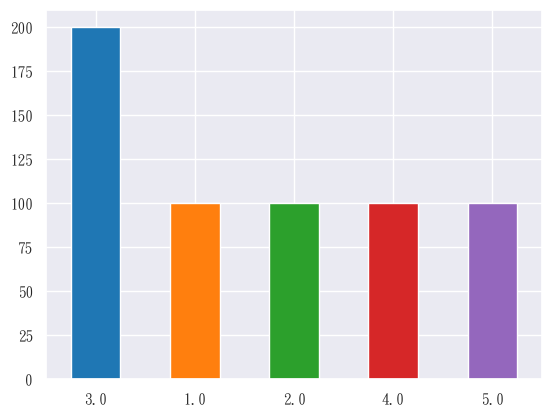

In [10]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
df_tmp['ratings'].value_counts().plot(kind="bar", rot=0, color=colors)

In [11]:
def get_sentiment(score):
    if score<=2:
        return 0 # negative sentiment
    elif score==3:
        return 1 # neutral sentiment
    else:
        return 2 # positive sentiment

df_tmp['sentiment'] = df_tmp.ratings.apply(get_sentiment)
# df_tmp[df_tmp['sentiment']==0]
df_tmp.sample()

,comments,ratings,wordcount,sentiment
66,容量太大一直顯示容量不足 明明有1G多 爛透了,1.0,24,0


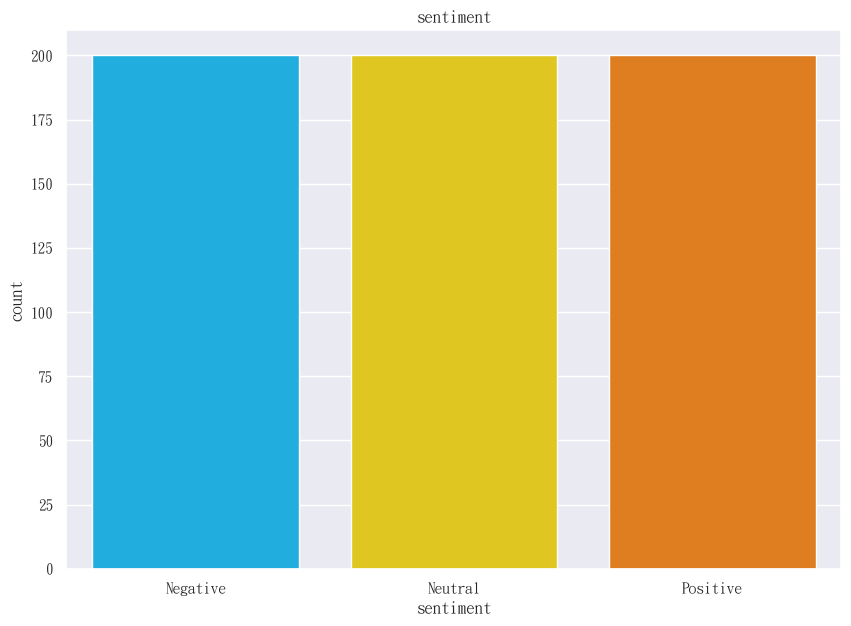

In [12]:
plt.figure(figsize=fig_size)
sns.countplot(data=df_tmp.loc[df_tmp['sentiment']!=-1], x='sentiment')
plt.xticks([0, 1, 2],['Negative','Neutral','Positive'])
plt.title('sentiment')
plt.show()

<a id="training_data"></a>
## Prepare training , validation  data

Finally we can see the balanced dataset.

- convert reviews into tokens
- convert tokens into token ids
- set max len
- creating padding
- all this will done by tokenizer.encode_plus

In [13]:
import transformers

In [14]:
bert_model_name = 'bert-base-chinese'
tokenizer = transformers.BertTokenizer.from_pretrained(bert_model_name)

In [15]:
sample_text = "自定義鍵盤中能不能不要有小愛心小花，看著真的不舒服"
               
tokens = tokenizer.tokenize(sample_text)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(f'{sample_text}')
print('='*60)
print(tokens)
print('='*60)
print(ids)

自定義鍵盤中能不能不要有小愛心小花，看著真的不舒服
['自', '定', '義', '鍵', '盤', '中', '能', '不', '能', '不', '要', '有', '小', '愛', '心', '小', '花', '，', '看', '著', '真', '的', '不', '舒', '服']
[5632, 2137, 5412, 7107, 4676, 704, 5543, 679, 5543, 679, 6206, 3300, 2207, 2695, 2552, 2207, 5709, 8024, 4692, 5865, 4696, 4638, 679, 5653, 3302]


In [16]:
# special tokens
print(tokenizer.sep_token , tokenizer.sep_token_id)
print(tokenizer.cls_token,tokenizer.cls_token_id)
print(tokenizer.unk_token,tokenizer.unk_token_id)
print(tokenizer.pad_token,tokenizer.pad_token_id)

[SEP] 102
[CLS] 101
[UNK] 100
[PAD] 0


Hugging face library provides another function called tokenizer.encode_plus() which we will use to perform almost entire  preprocessing steps in one go. It

* converts reviews into tokens
* adds [CLS] token at the beginning of input
* performs padding if sequence length is less than max_len
* performs truncation if sequence length is greater than max_len
* adds [SEP] token at the end of sequence.

In [17]:
encoding = tokenizer.encode_plus(
      sample_text,
      add_special_tokens=True,
      max_length=128,
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

R:\Anaconda3\envs\gpt\lib\site-packages\transformers\tokenization_utils_base.py:2370: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [18]:
print(encoding['input_ids'].shape)
encoding['input_ids']

torch.Size([1, 128])


tensor([[ 101, 5632, 2137, 5412, 7107, 4676,  704, 5543,  679, 5543,  679, 6206,
         3300, 2207, 2695, 2552, 2207, 5709, 8024, 4692, 5865, 4696, 4638,  679,
         5653, 3302,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [19]:
print(encoding['attention_mask'].shape)
encoding['attention_mask']

torch.Size([1, 128])


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

<a id="max_len"></a>
## Decide max_len

The best way to decide max_len for our task is plotting a distribution graph for the number of words in each review. We will assign max_len to that value for which most of the review is covered without truncation.

In [20]:
df_tmp.sample()

,comments,ratings,wordcount,sentiment
370,最好玩的時間烹飪遊戲,3.0,11,1


### max length of sequence 

R:\Anaconda3\envs\gpt\lib\site-packages\ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys


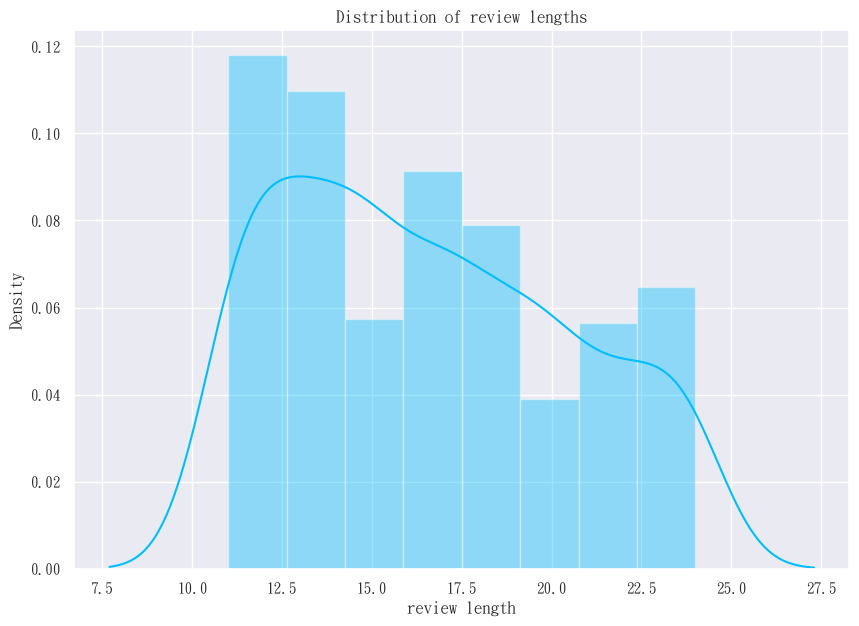

In [21]:
# Here is how we deal with English
# lengths = np.array([len(x.split()) for x in reviews_df.content])

# Chinese plot
lengths = np.array([len(x) for x in df_tmp.comments])
plt.figure(figsize = fig_size)
sns.distplot(lengths)
plt.xlabel('review length')
plt.title('Distribution of review lengths')
plt.show()

#### optimal max len = 128 will be fine, because we use Chinese for this training.

In [22]:
### Train , val and test data 
from sklearn.model_selection import train_test_split

train_df , test_df  = train_test_split(df_tmp, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)
val_df , test_df  = train_test_split(test_df, test_size=0.5, random_state=RANDOM_SEED, shuffle=True)

print(train_df.shape , test_df.shape , val_df.shape)

(480, 4) (60, 4) (60, 4)


<a id="dataset"></a>
## Dataset and Dataloader

We will use pytorch for fine tuing our BERT model for Sentiment analysis and we will use pytorch module such as Dataset and Dataloader which will finally convert out data into batches.

In [23]:
class GoogleAppReview(Dataset):
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self,index):
        review = self.review[index]
        encoding = self.tokenizer.encode_plus(
                          review,
                          add_special_tokens=True,
                          max_length=128,
                          truncation=True,
                          return_token_type_ids=False,
                          pad_to_max_length=True,
                          return_attention_mask=True,
                          return_tensors='pt')
        
        return {'review' : review,
                'input_id': encoding['input_ids'].flatten(),
                'attention_mask':encoding['attention_mask'].flatten(),
                'target': torch.tensor(self.target[index], dtype = torch.long)
               }

In [24]:
tokenizer = transformers.BertTokenizer.from_pretrained(bert_model_name)
MAX_LEN = 128

training_data = GoogleAppReview(review = train_df.comments.to_numpy(),
                               target = train_df.sentiment.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LEN)

validation_data = GoogleAppReview(review = val_df.comments.to_numpy(),
                               target = val_df.sentiment.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LEN)

test_data = GoogleAppReview(review = test_df.comments.to_numpy(),
                               target = test_df.sentiment.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LEN)

In [25]:
print(len(training_data),len(test_data),len(validation_data))

480 60 60


In [26]:
## DataLoader
BATCH_SIZE = 16
train_loader = DataLoader(training_data , batch_size = BATCH_SIZE , shuffle = True)
test_loader = DataLoader(test_data , batch_size = BATCH_SIZE , shuffle = False)
val_loader = DataLoader(validation_data , batch_size = BATCH_SIZE , shuffle = False)

In [27]:
sample_batch = next(iter(train_loader))
sample_batch.keys()

R:\Anaconda3\envs\gpt\lib\site-packages\transformers\tokenization_utils_base.py:2370: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['review', 'input_id', 'attention_mask', 'target'])

In [28]:
print(sample_batch['review'][0])
print(sample_batch['input_id'][0])
print(sample_batch['attention_mask'][0])
print(sample_batch['target'][0])
print('='*50)
print(sample_batch['input_id'].shape,sample_batch['attention_mask'].shape,sample_batch['target'].shape)

進不去…… 一直卡在初始畫面進不去~~~~~~~
tensor([ 101, 6868,  679, 1343,  100,  100,  671, 4684, 1305, 1762, 1159, 1993,
        4529, 7481, 6868,  679, 1343,  172,  172,  172,  172,  172,  172,  172,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

<a id="model_selection"></a>
## Model Selection

The BERT model comes with two configurations or we can say two different sizes BERT-base and BERT-large and we haven't talked about which model we are going to select. Performance wise BERT-large is more accurate as it has more bert-layer(24) and embedding size = 1024 but it is very hard to fine tune as I do not have any powerful GPUs on other hand BERT-base comes with 12 bert-layer and 768 embedding size which is much more easy to train as compare to BERT-large and performance wise also BERT-base give reasonably good performance.

By considering all those factors I will use BERT-base for our sentiment analysis model.

## Loading BERT-base model

In [29]:
# Load BERT base model
bert_model_name = 'bert-base-chinese'
bert_model = BertModel.from_pretrained(bert_model_name)

## testing the output of bert model
x = bert_model(sample_batch['input_id'].view(BATCH_SIZE,MAX_LEN)
               ,sample_batch['attention_mask'].view(BATCH_SIZE,MAX_LEN))

print('Last hidden layer size for input as batch',x[0].shape)
print('Pooled output size for input as batch',x[1].shape)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Last hidden layer size for input as batch torch.Size([16, 128, 768])
Pooled output size for input as batch torch.Size([16, 768])


## Model Architecture

We will add one more linear layer on top of the BERT-base model which takes inputs from a pooled layer of BERT base and generates 3D output for each input. These three outputs will indicate the chance of a review to its respective sentiments where First output represents Negative and second and third output represents Neutral and positive respectively.

In [30]:
## build model 

class SentimentClassifier(nn.Module):
    def __init__(self,num_classes):
        super(SentimentClassifier,self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(p = 0.3)
        self.linear = nn.Linear(self.bert.config.hidden_size,num_classes)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self,input_ids , attention_mask):
        temp = self.bert(input_ids,attention_mask) # Here we have added one linear layer on top of 
        pooled_output = temp[1]                    # BERT-base with number of output = 3 
        out = self.dropout(pooled_output)          #
        out = self.linear(out)
        return out

In [31]:
num_classes = 3
model = SentimentClassifier(num_classes)

sample_linear_output = model(sample_batch['input_id']
                             ,sample_batch['attention_mask'])

s = nn.Softmax(dim=1)
final_out = s(sample_linear_output)
final_out

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[0.3956, 0.2160, 0.3884],
        [0.1945, 0.3359, 0.4696],
        [0.0823, 0.2359, 0.6818],
        [0.2372, 0.2793, 0.4834],
        [0.2739, 0.2373, 0.4888],
        [0.3191, 0.1904, 0.4904],
        [0.3104, 0.2259, 0.4637],
        [0.4005, 0.2369, 0.3626],
        [0.2575, 0.4208, 0.3217],
        [0.2977, 0.2479, 0.4544],
        [0.3839, 0.2442, 0.3718],
        [0.2154, 0.2410, 0.5436],
        [0.1980, 0.2822, 0.5198],
        [0.3206, 0.1969, 0.4825],
        [0.3437, 0.2003, 0.4560],
        [0.2657, 0.2891, 0.4453]], grad_fn=<SoftmaxBackward>)

Till now everything looks fine. We got output(16,3) for the sample batch where 16 is sample size and 3 is number of outputs for each input. 

The following initial steps are performed to train any deep learning model using pytorch which are
* define loss function
* define optimizer
* define scheduler (it will modify learning rate after each iteration that speed-up the convergence. using it is optional but recommended)

In [32]:
## loss and optimizer
learning_rate = 1e-5
EPOCHS = 3
total_steps = len(train_loader) * EPOCHS

criterian = torch.nn.CrossEntropyLoss()

optimizer = transformers.AdamW(params = model.parameters(),lr = learning_rate, correct_bias= False)

scheduler = transformers.get_linear_schedule_with_warmup(optimizer = optimizer,
                                                        num_warmup_steps = 0,
                                                        num_training_steps = total_steps)

R:\Anaconda3\envs\gpt\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [33]:
def train_model(model, data_loader, criterian, optimizer, scheduler, BATCH_SIZE ,MAX_LEN, n_examples):
    model.train()
    train_loss = []
    correct_pred = 0
    for d in data_loader:
        input_ids = d['input_id']
        attention_masks = d['attention_mask']
        targets = d['target']

        # forward prop
        predictions = model(input_ids , attention_masks)
        loss = criterian(predictions, targets)
        _,pred_classes = torch.max(predictions, dim=1)
        # backprop
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # hack to avoid gradient explotion
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        # training loss and number of correct prediction
        train_loss.append(loss.item())
        correct_pred += torch.sum(pred_classes==targets)
    return correct_pred / n_examples , np.mean(train_loss)

In [34]:
def eval_model(model, data_loader, criterian, BATCH_SIZE ,MAX_LEN, n_examples):
    model.eval()  # to make model in evaluastion model , Dropout will not apply 
    eval_loss = []
    correct_pred = 0
    with torch.no_grad():  # calculation of gradient is not required on evaluation
        for d in data_loader:
            input_ids = d['input_id']
            attention_masks = d['attention_mask']
            targets = d['target']

            # forward prop
            predictions = model(input_ids , attention_masks)
            loss = criterian(predictions, targets)
            _,pred_classes = torch.max(predictions, dim=1)

            eval_loss.append(loss.item())
            correct_pred += torch.sum(pred_classes==targets)
    return correct_pred / n_examples , np.mean(eval_loss)

In [35]:
import os

folder_path = "model/bert_sentiment/"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder created: {folder_path}")
else:
    print(f"Folder already exists: {folder_path}")

Folder created: model/bert_sentiment/


In [36]:
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    # training part 
    print(f'epoch : {epoch+1}/{EPOCHS}')
    model = SentimentClassifier(num_classes)
    train_acc , train_loss = train_model(model,
                                         train_loader,
                                         criterian,
                                         optimizer, 
                                         scheduler, 
                                         BATCH_SIZE,
                                         MAX_LEN,
                                         len(train_df))
    # validation part
    val_acc , val_loss = eval_model(model, 
                                    val_loader,
                                    criterian,
                                    BATCH_SIZE,
                                    MAX_LEN, len(val_df))
    
    # saving training logs
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    print(f'train_loss: {train_loss}, train_acc: {train_acc} ,val_loss: {val_loss}, val_acc: {val_acc}')

    # saving model if performance improved 
    if val_acc > best_accuracy:
        best_model_name = f'model/bert_sentiment/best_model_state_{val_acc}.bin'
        torch.save(model.state_dict(), best_model_name)
        best_accuracy = val_acc

epoch : 1/3


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train_loss: 1.1545452992121379, train_acc: 0.3687500059604645 ,val_loss: 1.0947777032852173, val_acc: 0.36666667461395264
epoch : 2/3


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train_loss: 1.1904264827569326, train_acc: 0.35208332538604736 ,val_loss: 1.114891916513443, val_acc: 0.3499999940395355
epoch : 3/3


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train_loss: 1.1797544320424398, train_acc: 0.31458333134651184 ,val_loss: 1.1074974238872528, val_acc: 0.3333333432674408


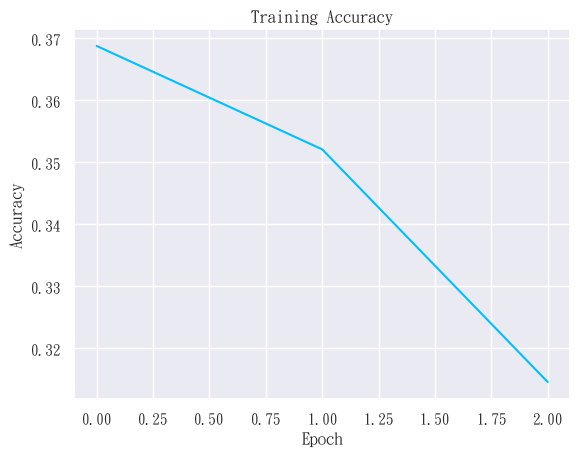

In [37]:
import matplotlib.pyplot as plt

# Extract the training accuracy values from history
train_acc_values = history['train_acc']

# Plot the training accuracy values
plt.plot(train_acc_values)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

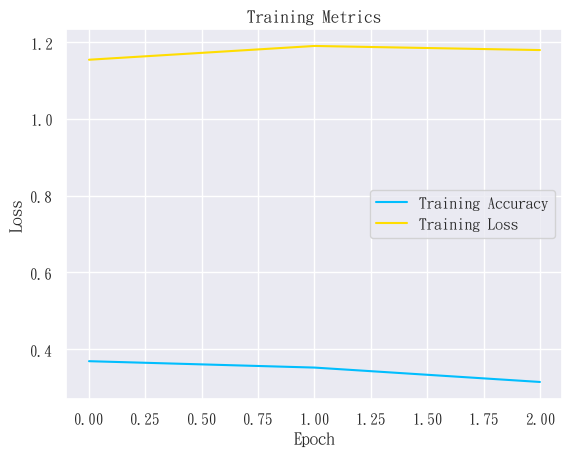

In [38]:
import matplotlib.pyplot as plt

# Extract the training accuracy and loss values from history
train_acc_values = history['train_acc']
train_loss_values = history['train_loss']

# Create a new figure and plot the training accuracy values
fig, ax = plt.subplots()
ax.plot(train_acc_values, label='Training Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# Plot the training loss values on the same axis
ax.plot(train_loss_values, label='Training Loss')
ax.set_ylabel('Loss')

# Add a title and legend to the plot
ax.set_title('Training Metrics')
ax.legend()

# Display the plot
plt.show()

<a id="load_own_bert"></a>
## Load our own bert model

In [39]:
num_classes = 3
model = SentimentClassifier(num_classes)
model.load_state_dict(torch.load('model/bert_sentiment/best_model_state.bin', map_location=torch.device('cpu')))

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

## Evaluation Final model on Test data

In [40]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in tqdm(data_loader):

            texts = d["review"]
            input_ids = d["input_id"]
            attention_mask = d["attention_mask"]
            targets = d["target"]

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [41]:
from tqdm import tqdm
import torch.nn.functional as F

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_loader)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.45it/s]


In [42]:
from sklearn.metrics import classification_report

class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.44      0.55      0.49        20
     neutral       0.00      0.00      0.00        20
    positive       0.34      0.60      0.44        20

    accuracy                           0.38        60
   macro avg       0.26      0.38      0.31        60
weighted avg       0.26      0.38      0.31        60



R:\Anaconda3\envs\gpt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
R:\Anaconda3\envs\gpt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
R:\Anaconda3\envs\gpt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


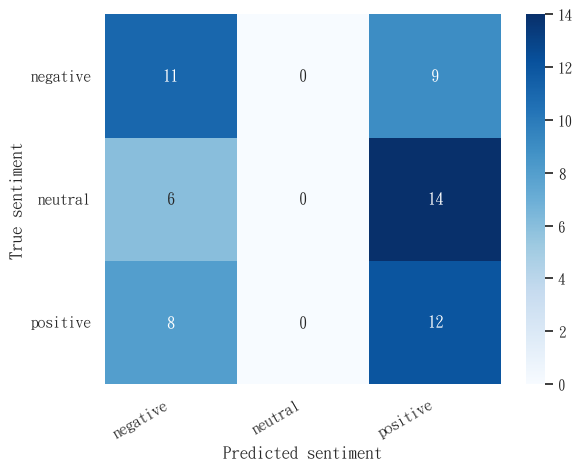

In [43]:
import pandas as pd
from sklearn.metrics import confusion_matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

<a id="testing"></a>
## Testing model performance on unseen data

In [44]:
### Predicting on Raw text data

def get_sentiment(sample_review):
    # get input ids and attention mask
    encode_sample_review = tokenizer.encode_plus(
                              sample_review,
                              add_special_tokens=True,
                              max_length=128,
                              truncation=True,
                              return_token_type_ids=False,
                              pad_to_max_length=True,
                              return_attention_mask=True,
                              return_tensors='pt')

    input_ids = encode_sample_review['input_ids']
    attention_mask = encode_sample_review['attention_mask']
    # predict output
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    # output as probabilities
    pred_probs = F.softmax(output,dim=1).detach().numpy().reshape(3)
    
    class_names = ['negative', 'neutral', 'positive']
    data = {'class_names':class_names, 
            'value':pred_probs} 

    # Create DataFrame 
    df = pd.DataFrame(data)
    # plot bars for probability of each sentiment
    sns.barplot(x='value', y='class_names', data=df, orient='h')
    plt.ylabel('sentiment')
    plt.xlabel('probability')
    plt.xlim([0, 1]);
    print(f'Review text: {sample_review}')
    print('=*'*50)

    print(f'negative % : {pred_probs[0]:.4f}, neutral % : {pred_probs[1]:.4f}, positive % : {pred_probs[2]:.4f}')

    print(f'Sentiment  : {class_names[prediction]}')

Review text: UI很好用
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
negative % : 0.3183, neutral % : 0.2992, positive % : 0.3825
Sentiment  : positive


R:\Anaconda3\envs\gpt\lib\site-packages\transformers\tokenization_utils_base.py:2370: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


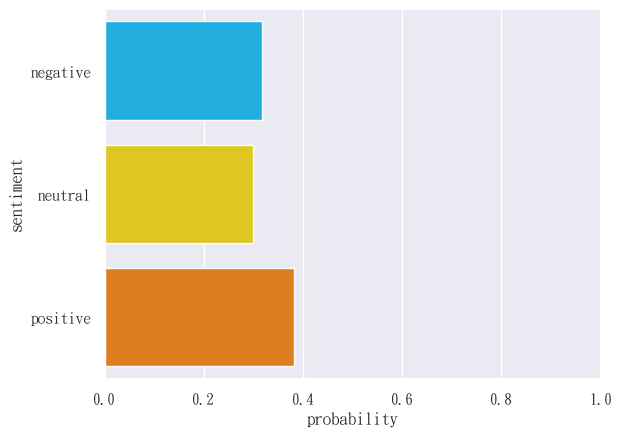

In [45]:
sample_review = "UI很好用"

get_sentiment(sample_review)